In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer

sns.set()

In [123]:
# --- 1. Load Data ---
cars = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [124]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


In [125]:
cars.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,74452,72,Ford,14808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,74451,40,Manual,38050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74510.0,NaN,NaN,NaN,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.0
fuelType,74462,34,Petrol,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,68069.0,NaN,NaN,NaN,120.329078,65.521176,-91.12163,125.0,145.0,145.0,580.0
mpg,68047.0,NaN,NaN,NaN,55.152666,16.497837,-43.421768,46.3,54.3,62.8,470.8


In [126]:
cars.shape

(75973, 14)

In [127]:
print("--- Inspection of Categorical Features (Unique Values) ---")
for col in ['Brand', 'transmission', 'fuelType']:
    print(f"\n--- Column: {col} ---")
    
    # 2.1. Normalize Casing
    # Apply title case for consistent counting (e.g., 'petrol' and 'Petrol' become 'Petrol')
    normalized_series = cars[col].astype(str).str.title().str.strip()
    
    # 2.2. Get Value Counts
    # Use value_counts(dropna=False) to include NaN counts (represented as 'Nan' after astype(str))
    counts = normalized_series.value_counts(dropna=False)
    
    # 2.3. Output Results
    if len(counts) > 50:
        # For high-cardinality columns (like Brand), show the top 10 counts
        print(f"Total Unique Values: {len(counts) - (1 if 'Nan' in counts.index else 0)}")
        print(f"Top 10 Values and their Occurrences:")
        print(counts.nlargest(10).to_markdown(numalign="left", stralign="left"))
    else:
        # For low-cardinality columns (transmission, fuelType), show all counts
        print("All Unique Values and their Occurrences:")
        print(counts.to_markdown(numalign="left", stralign="left"))

--- Inspection of Categorical Features (Unique Values) ---

--- Column: Brand ---
All Unique Values and their Occurrences:
| Brand    | count   |
|:---------|:--------|
| Ford     | 15431   |
| Mercedes | 11209   |
| Vw       | 9973    |
| Opel     | 8979    |
| Bmw      | 7102    |
| Audi     | 7028    |
| Toyota   | 4455    |
| Skoda    | 4138    |
| Hyundai  | 3201    |
| Nan      | 1521    |
| Ord      | 320     |
| For      | 305     |
| Ercedes  | 236     |
| Mercede  | 222     |
| W        | 208     |
| V        | 204     |
| Ope      | 188     |
| Pel      | 181     |
| Mw       | 149     |
| Aud      | 147     |
| Udi      | 147     |
| Bm       | 141     |
| Oyota    | 93      |
| Koda     | 82      |
| Skod     | 81      |
| Toyot    | 74      |
| Yundai   | 68      |
| Hyunda   | 64      |
| Ercede   | 7       |
| Or       | 7       |
| Pe       | 4       |
| Yunda    | 3       |
| Ud       | 3       |
| Kod      | 2       |

--- Column: transmission ---
All Unique Values a

In [128]:
cars['transmission'] = cars['transmission'].astype(str).str.title()

# 1.2. Manually replace the identified typo 'Anual' with the correct 'Manual'
# The .replace() method will only change the specified value.
cars['transmission'] = cars['transmission'].replace([' Manual ', 'Manual ', ' Manual', 'Anual', 'Manua', 'Anua'], 'Manual')
cars['transmission'] = cars['transmission'].replace(['Semi-Aut', 'Emi-Auto', 'Emi-Aut'], 'Semi-Auto')
cars['transmission'] = cars['transmission'].replace(['Automati', 'Utomatic', 'Utomati', 'Utomatic'], 'Automatic')
cars['transmission'] = cars['transmission'].replace(['Unknow', 'Nknown', 'Nknow'], 'Unknown')

cars['Brand'] = cars['Brand'].astype(str).str.title()
cars['Brand'] = cars['Brand'].replace(['Ord', 'For', 'Or'], 'Ford')
cars['Brand'] = cars['Brand'].replace(['Ercedes', 'Mercede', 'Ercede'], 'Mercedes')
cars['Brand'] = cars['Brand'].replace(['Skod', 'Koda', 'Kod'], 'Skoda')
cars['Brand'] = cars['Brand'].replace(['Ope', 'Pel', 'Pe'], 'Opel')
cars['Brand'] = cars['Brand'].replace(['Aud', 'Udi', 'Ud'], 'Audi')
cars['Brand'] = cars['Brand'].replace(['Bm', 'Mw'], 'Bmw')
cars['Brand'] = cars['Brand'].replace(['Yundai', 'Hyunda', 'Yunda'], 'Hyundai')
cars['Brand'] = cars['Brand'].replace(['Oyota', 'Toyot', 'Ercede'], 'Toyota')
cars['Brand'] = cars['Brand'].replace(['V', 'W'], 'Vw')

cars['fuelType'] = cars['fuelType'].astype(str).str.title()
cars['fuelType'] = cars['fuelType'].replace(['Petro', 'Etrol', 'Etro'], 'Petrol')
cars['fuelType'] = cars['fuelType'].replace(['Iesel', 'Diese', 'Iese'], 'Diesel')
cars['fuelType'] = cars['fuelType'].replace(['Hybri', 'Ybrid', 'Ybri'], 'Hybrid')
cars['fuelType'] = cars['fuelType'].replace(['Othe', 'Ther'], 'Other')

In [129]:
# replace negative values
print(f'Milage have {(cars['mileage'] < 0).sum()} negative values')
cars['mileage'] = cars['mileage'].apply(lambda x: x if x>=0 else np.nan)

print(f'Miles per gallon have {(cars['mpg'] < 0).sum()} negative values')
cars['mpg'] = cars['mpg'].apply(lambda x: x if x>=0 else np.nan)

print(f'Tax have {(cars['tax'] < 0).sum()} negative values')
cars['tax'] = cars['tax'].apply(lambda x: x if x>=0 else np.nan)

print(f'engineSize have {(cars['engineSize'] < 0).sum()} negative values')
cars['engineSize'] = cars['engineSize'].apply(lambda x: x if x>=0 else np.nan)

print(f'previousOwners have {(cars['previousOwners'] < 0).sum()} negative values')
cars['previousOwners'] = cars['previousOwners'].apply(
    lambda x: int(x) if pd.notna(x) else np.nan
)
cars.loc[cars['previousOwners'] < 0, 'previousOwners'] = pd.NA


Milage have 369 negative values
Miles per gallon have 36 negative values
Tax have 378 negative values
engineSize have 84 negative values
previousOwners have 371 negative values


In [130]:
cars['fuelType'].isna().sum()

np.int64(0)

In [131]:
cars.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,75973,10,Ford,16063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,75973,6,Manual,41627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74141.0,NaN,NaN,NaN,23352.797092,21620.630248,1.0,7556.0,17416.0,32510.0,323000.0
fuelType,75973,6,Petrol,41181,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,67691.0,NaN,NaN,NaN,121.259276,64.493191,0.0,125.0,145.0,145.0,580.0
mpg,68011.0,NaN,NaN,NaN,55.204844,16.345534,1.1,46.3,54.3,62.8,470.8


In [132]:
X = cars.drop(['carID', 'model', 'hasDamage'], axis = 1)
y = cars['price']

In [133]:
for feature in X.columns:
    print(f'There are {X[feature].isna().sum()} Nan values in {feature}')

There are 0 Nan values in Brand
There are 1491 Nan values in year
There are 0 Nan values in price
There are 0 Nan values in transmission
There are 1832 Nan values in mileage
There are 0 Nan values in fuelType
There are 8282 Nan values in tax
There are 7962 Nan values in mpg
There are 1600 Nan values in engineSize
There are 1524 Nan values in paintQuality%
There are 1921 Nan values in previousOwners


In [134]:
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']
categorical_features = ['Brand', 'transmission', 'fuelType']

In [135]:
X['year'].median()

2017.0

In [136]:
for col in numerical_features:
    median_val = X[col].median()
    print(f'Median of {col} is {median_val}')
    X[col] = X[col].fillna(median_val)

Median of year is 2017.0
Median of mileage is 17416.0
Median of tax is 145.0
Median of mpg is 54.3
Median of engineSize is 1.6
Median of paintQuality% is 65.0
Median of previousOwners is 2.0


In [137]:
X['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Nan', 'Other', 'Electric'],
      dtype=object)

In [138]:
for col in categorical_features:
    X[col] = X[col].replace('Nan', np.nan)
    mode_val = X[col].mode()[0]
    X[col] = X[col].fillna(mode_val)

In [139]:
X['previousOwners'] = X['previousOwners'].astype('int64')
X['year'] = X['year'].astype('int64')

In [140]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           75973 non-null  object 
 1   year            75973 non-null  int64  
 2   price           75973 non-null  int64  
 3   transmission    75973 non-null  object 
 4   mileage         75973 non-null  float64
 5   fuelType        75973 non-null  object 
 6   tax             75973 non-null  float64
 7   mpg             75973 non-null  float64
 8   engineSize      75973 non-null  float64
 9   paintQuality%   75973 non-null  float64
 10  previousOwners  75973 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 6.4+ MB


In [141]:
X['year'].unique()

array([2016, 2019, 2018, 2014, 2017, 2020, 2013, 2015, 2023, 2011, 2012,
       2003, 2009, 2007, 2005, 2004, 2010, 2008, 2024, 2006, 2001, 2000,
       2002, 2022, 1996, 1998, 1970, 1999, 1997])

In [142]:
X_encoded = pd.get_dummies(
    X, 
    columns=categorical_features, 
    drop_first=False,
    dtype=int
)

In [143]:
X_numeric = X.drop(['transmission', 'Brand', 'fuelType'], axis=1)

In [144]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [145]:
spearman_cor = X_numeric.corr(method='spearman')

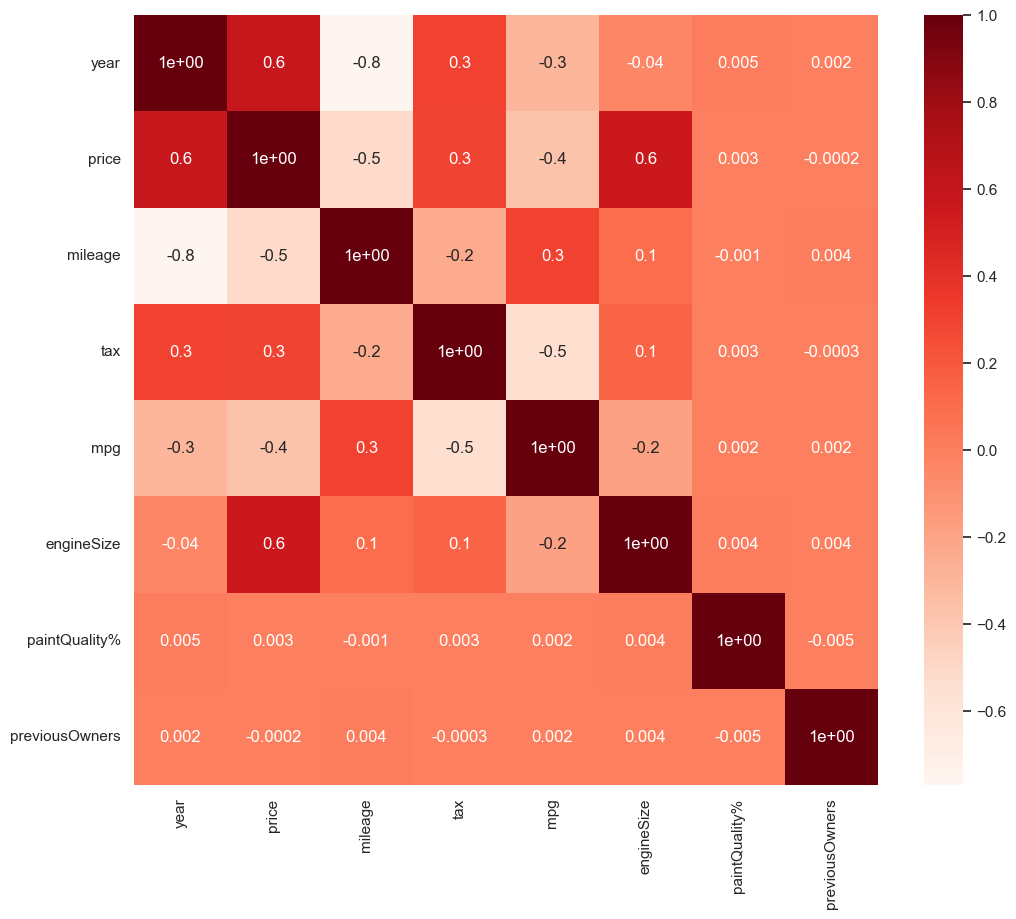

In [146]:
cor_heatmap(spearman_cor)

# MARGARIDA - ML

In [185]:
# Fix mixed data types and encode empty, nan and none values to unknown because filling with mode could assign the wrong brand and bias price

cat_cols = ['Brand','model','transmission','fuelType']

# Convert to string, strip whitespace, normalize case (title() keeps proper nouns readable) and the rest into unknown category
for col in cat_cols:
    cars[col] = cars[col].astype(str).str.strip().str.title().replace({'Nan':'Unknown','None':'Unknown','Na':'Unknown', '':'Unknown'})
    test[col]  = test[col].astype(str).str.strip().str.title().replace({'Nan':'Unknown','None':'Unknown','Na':'Unknown','':'Unknown'})

In [190]:
print(" VALIDATION OF CATEGORICAL CLEANING \n")

# Check that all entries are strings
for col in cat_cols:
    print(f"Column: {col}")
    print(cars[col].map(type).value_counts())
    print()

# Check for NaNs (should be 0 now)
print("Missing values per categorical column:")
print(cars[cat_cols].isna().sum(), "\n")

# Check for weird values ('nan', 'none', 'null', empty strings)
for col in cat_cols:
    weird_values = [x for x in cars[col].unique() if str(x).strip().lower() in ['nan','none','null','']]
    print(f"{col}: weird values found -> {weird_values}")
print()

 VALIDATION OF CATEGORICAL CLEANING 

Column: Brand
Brand
<class 'str'>    75793
Name: count, dtype: int64

Column: model
model
<class 'str'>    75793
Name: count, dtype: int64

Column: transmission
transmission
<class 'str'>    75793
Name: count, dtype: int64

Column: fuelType
fuelType
<class 'str'>    75793
Name: count, dtype: int64

Missing values per categorical column:
Brand           0
model           0
transmission    0
fuelType        0
dtype: int64 

Brand: weird values found -> []
model: weird values found -> []
transmission: weird values found -> []
fuelType: weird values found -> []



In [202]:
# I think we should combine rare categories in an Other or Unknown gorup after cleaning the model column of course

# Define threshold for rarity (e.g., 5% of total rows)
threshold = 0.05  

for col in cat_cols:
    # Get value counts as a proportion
    freq = cars[col].value_counts(normalize=True)
    
    # Identify rare categories
    rare_categories = freq[freq < threshold].index.tolist()
    
    if rare_categories:
        print(f"Column '{col}' has rare categories: {rare_categories}")
    else:
        print(f"Column '{col}' has no rare categories above threshold")

Column 'Brand' has rare categories: ['Hyundai', 'Unknown']
Column 'model' has rare categories: ['Golf', 'Corsa', 'Polo', 'Astra', 'A Class', '3 Series', 'Unknown', 'Kuga', 'Yaris', 'Mokka X', 'Aygo', '1 Series', 'E Class', 'A3', 'Tiguan', 'Fabia', 'Octavia', 'Q3', 'A4', 'A1', 'Tucson', '2 Series', 'Ecosport', '5 Series', 'Insignia', 'I10', 'Glc Class', '4 Series', 'Passat', 'Up', 'Mokka', 'Q5', 'A5', 'Gla Class', 'X1', 'Q2', 'Superb', 'Auris', 'T-Roc', 'A6', 'Crossland X', 'B Class', 'Zafira', 'Grandland X', 'C-Max', 'I30', 'X3', 'Ka+', 'Mondeo', 'Cl Class', 'Gle Class', 'C-Hr', 'Yeti Outdoor', 'Adam', 'I20', 'Citigo', 'Rav4', 'Kodiaq', 'X5', 'Viva', 'Q7', 'Karoq', 'B-Max', 'Touran', 'Touareg', 'Kona', 'T-Cross', 'Tt', 'Ioniq', 'S-Max', 'X2', 'Sl Class', 'Sharan', 'Meriva', 'Golf Sv', 'Arteon', 'Scirocco', 'Corolla', 'Prius', 'Cls Class', 'Santa Fe', 'Grand C-Max', 'Ka', 'Scala', 'Galaxy', 'Ix20', 'V Class', 'Edge', 'S Class', 'X4', 'Kamiq', 'Rapid', 'Combo Life', 'A', 'Yeti', 'Gl Clas

In [193]:
# Fix negative values on numerical columns that should not have negative values

num_cols = ['mileage','mpg','tax','engineSize','previousOwners']
for c in num_cols:
    cars.loc[cars[c] < 0, c] = np.nan
    test.loc[test[c] < 0, c] = np.nan

for c in num_cols:
    neg_mask = cars[c] < 0
    print(c, neg_mask.sum())


mileage 0
mpg 0
tax 0
engineSize 0
previousOwners 0


In [204]:
# Impute missing values using training medians of the numerical values

medians = {
    'mileage': 17416.0,
    'tax': 145.0,
    'mpg': 54.3,
    'engineSize': 1.6,
    'paintQuality%': 65.0,
    'previousOwners': 2.0
}

for c, v in medians.items():
    cars[c] = cars[c].fillna(v)
    test[c] = test[c].fillna(v)


In [205]:
# Does not make sense to put median in the missing values of columns

# Add a column for the year missing that might help the model learn different price patterns and be more accurate
cars['year_missing'] = cars['year'].isna().astype(int)
test['year_missing'] = test['year'].isna().astype(int)


# Then fill by using the median years of same brand and model 
cars['year'] = cars.groupby(['Brand','model'])['year'].transform(lambda x: x.fillna(x.median()))
test['year'] = test.groupby(['Brand','model'])['year'].transform(lambda x: x.fillna(x.median()))


# For any that still remain missing, fill with mode year
mode_year = cars['year'].mode()[0]
cars['year'] = cars['year'].fillna(mode_year)
test['year'] = test['year'].fillna(mode_year)

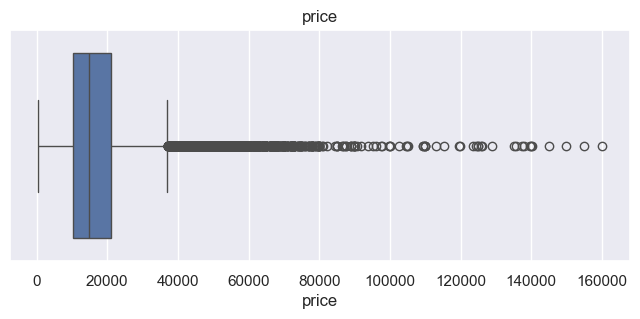

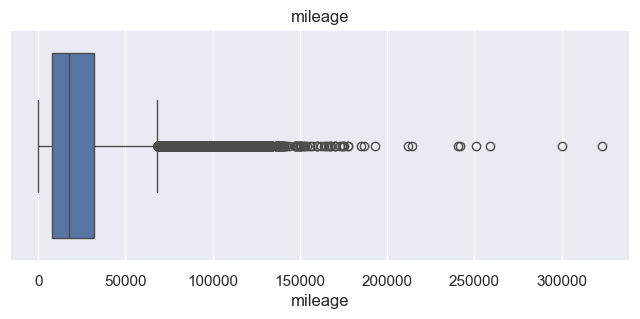

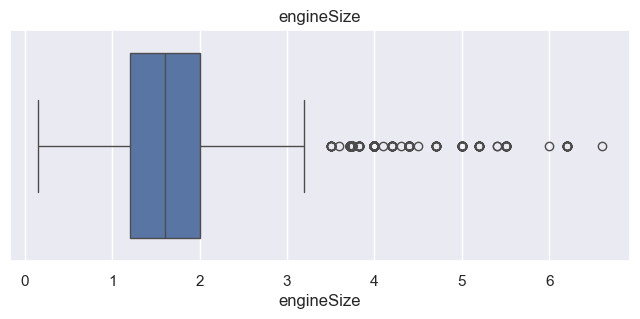

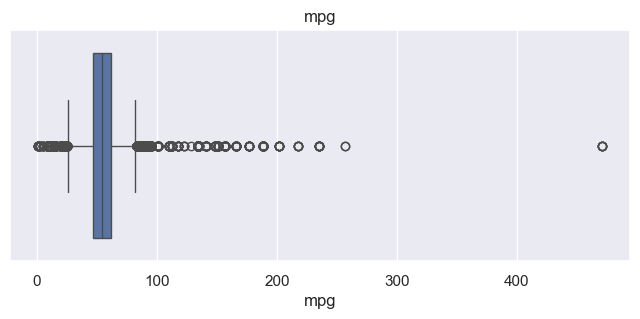

In [206]:
# Detect Outliers

def iqr_outlier_bounds(s, k=1.5):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - k*IQR, Q3 + k*IQR

numeric_features = ['year','mileage','tax','mpg','engineSize','paintQuality%','previousOwners','price']
outlier_summary = {}
for col in numeric_features:
    lb, ub = iqr_outlier_bounds(cars[col].dropna(), k=1.5)
    n_out = ((cars[col] < lb) | (cars[col] > ub)).sum()
    outlier_summary[col] = {'lower':lb, 'upper':ub, 'count':int(n_out), 'pct':100*int(n_out)/len(cars)}
outlier_summary

for col in ['price','mileage','engineSize','mpg']:
    plt.figure(figsize=(8,3))
    sns.boxplot(x=cars[col])
    plt.title(col)
    plt.show()

In [207]:
# Cap numeric features at 1st and 99th percentiles - called winsorize

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    low = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

for col in ['mileage','price','engineSize','tax','mpg']:
    cars[col+'_wins'] = winsorize_series(cars[col])

for col in ['mileage','engineSize','tax','mpg']:
    test[col+'_wins'] = winsorize_series(test[col])

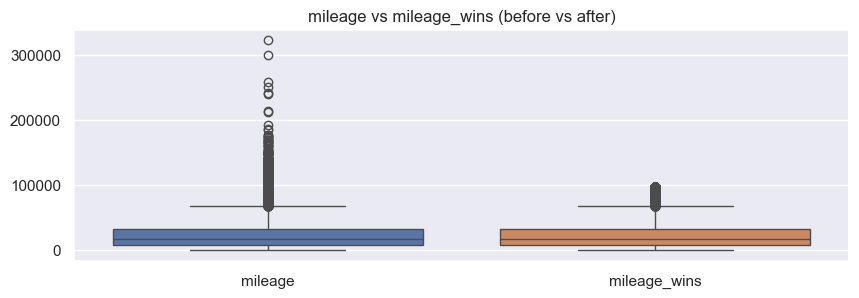

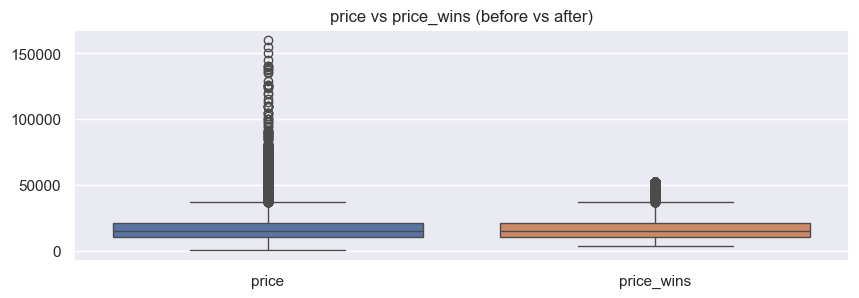

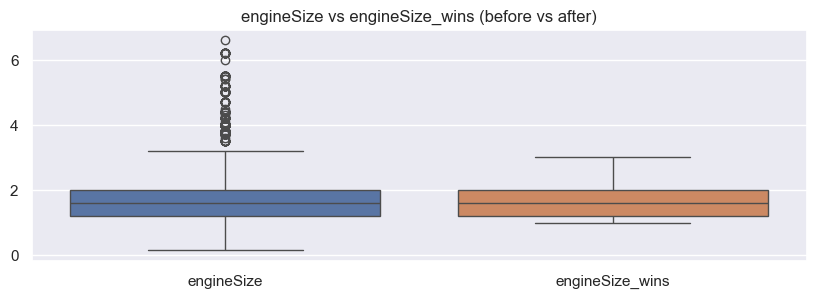

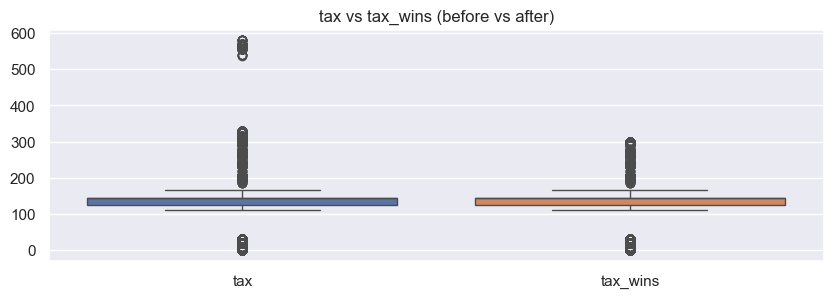

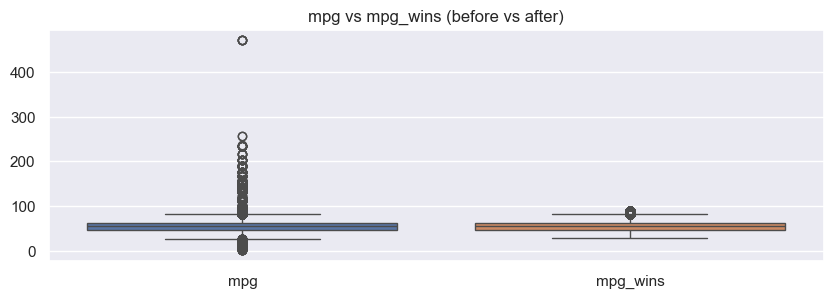

In [208]:
# See before and after results

import seaborn as sns
import matplotlib.pyplot as plt

for col in ['mileage','price','engineSize','tax','mpg']:
    plt.figure(figsize=(10,3))
    sns.boxplot(data=cars[[col, col+'_wins']])
    plt.title(f"{col} vs {col}_wins (before vs after)")
    plt.show()


In [209]:
# If skew > 1 -> highly skewed to the right consider log transform

print(cars[['price','mileage','engineSize','tax','mpg']].skew())

price         2.285820
mileage       1.836870
engineSize    1.375129
tax          -0.012315
mpg           4.063873
dtype: float64


In [210]:
# Use transform log on features skewed to the right

cars['price_log'] = np.log1p(cars['price'])
cars['mileage_log'] = np.log1p(cars['mileage'])
test['mileage_log'] = np.log1p(test['mileage'])
cars['mpg_log'] = np.log1p(cars['mpg'])
test['mpg_log'] = np.log1p(test['mpg'])

# If we build a model to predict price_log you can get the actual price by applying the inverse transform np.expm1(predicted_log)

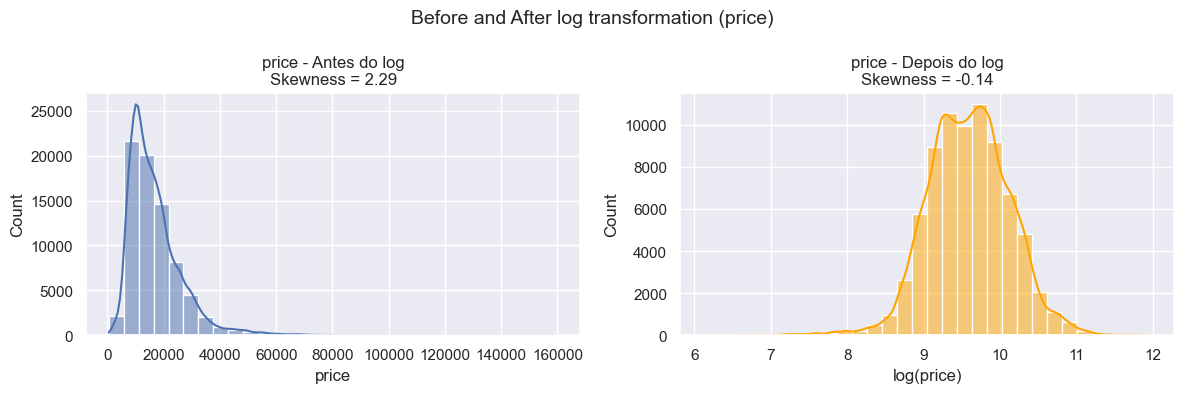

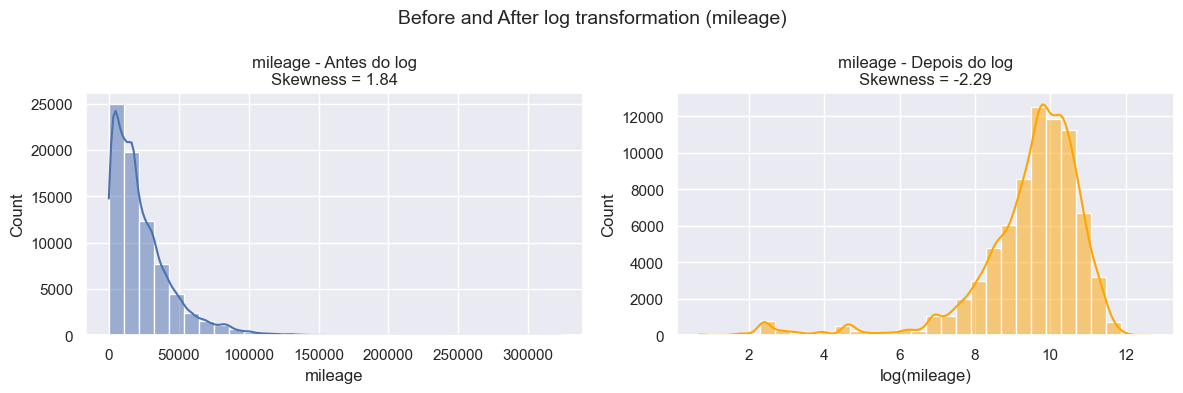

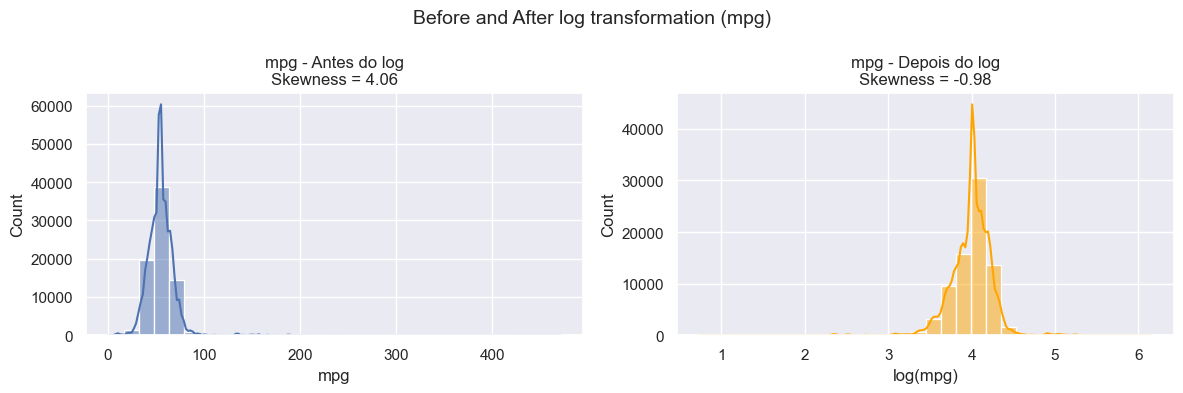

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ['price', 'mileage', 'mpg']

for col in cols:
    # Calculate skewness
    skew_before = cars[col].skew()
    skew_after = np.log1p(cars[col]).skew()

    # Create graphs
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(cars[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} - Antes do log\nSkewness = {skew_before:.2f}")
    axes[0].set_xlabel(col)

    sns.histplot(np.log1p(cars[col]), bins=30, kde=True, color='orange', ax=axes[1])
    axes[1].set_title(f"{col} - Depois do log\nSkewness = {skew_after:.2f}")
    axes[1].set_xlabel(f"log({col})")

    plt.suptitle(f"Before and After log transformation ({col})", fontsize=14)
    plt.tight_layout()
    plt.show()


In [212]:
#Skew went too far negative for mileage. This can happen if many very small values exist
#Log compresses high values.
#Might need a different transform like square root.

In [213]:
# Apply square root transformation to mileage - compresses high numbers making distribution more balanced

cars['mileage_sqrt'] = np.sqrt(cars['mileage'])
test['mileage_sqrt'] = np.sqrt(test['mileage'])

# Check new skewness
print("Mileage skew after sqrt:", cars['mileage_sqrt'].skew())


Mileage skew after sqrt: 0.41542860243947455


In [214]:
# Check no negative values remain

for c in ['mileage','mpg','tax','engineSize','previousOwners']:
    print(c, (cars[c] < 0).sum())

mileage 0
mpg 0
tax 0
engineSize 0
previousOwners 0


In [215]:
# Check missing counts are as expected (ideally zero for required fields)
print(cars.isna().sum())

carID              0
Brand              0
model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax                0
mpg                0
engineSize         0
paintQuality%      0
previousOwners     0
year_missing       0
mileage_wins       0
price_wins         0
engineSize_wins    0
tax_wins           0
mpg_wins           0
price_log          0
mileage_log        0
mpg_log            0
mileage_sqrt       0
dtype: int64


In [164]:
# Dropping the column "has damage" because it is all zeros

cars = cars.drop(columns=['hasDamage'])
test = test.drop(columns=['hasDamage'])

In [ ]:
# Feature engineering ideas

# Age = 2020 - year (or current year - year). Age is more interpretable than year.
# km_per_year = mileage / age (handle age==0).
# Brand_price_median: target-encode brand by median price per brand (compute on train only, then map to test).
# High_mileage_flag: mileage > threshold.
# Interaction: engineSize * mpg or engineSize / mileage.

